# VSWR simulation
- https://en.wikipedia.org/wiki/Standing_wave_ratio  
- https://en.wikipedia.org/wiki/Reflections_of_signals_on_conducting_lines
- https://www.youtube.com/watch?v=BSa051lWB_c
- https://www.youtube.com/watch?v=BijMGKbT0Wk 
- https://zh.wikipedia.org/wiki/%E9%98%BB%E6%8A%97%E5%8C%B9%E9%85%8D
- https://zh.wikipedia.org/wiki/%E5%8F%B2%E5%AF%86%E6%96%AF%E5%9B%BE


In [1]:
import os, sys

def gen_relative_path(target_path): 
    
    def del_same_parents(target_path, current_path):
        if len(target_path) * len(current_path) > 0:
            if target_path[0] == current_path[0]:
                target_path.pop(0)
                current_path.pop(0)
                del_same_parents(target_path, current_path)
            
    current_path = os.getcwd().replace('\\', '/').split('/')
    target_path = target_path.replace('\\', '/').split('/')
    del_same_parents(target_path, current_path)
    
    return ['..'] * len(current_path) + target_path


def append_source_relative_path(source_relative_path):
    sys.path.append(os.sep.join(source_relative_path))

In [2]:
# paths = ['']
# paths = [gen_relative_path(p) for p in paths]
# print(paths)

In [3]:
paths = [['..', '..', '..', '..', '..', 'Waves', 'bitbucket', 'github', 'codes'],
         ['..', 'codes']]

for path in paths:
    append_source_relative_path(path)

In [4]:
%pylab inline

from waves.sound import * 

Populating the interactive namespace from numpy and matplotlib


In [5]:
import warnings 

warnings.filterwarnings('ignore')

In [6]:
from ipywidgets import interactive

# interactive(process, amp_I = (0, 1, 1/4), amp_Q = (0, 1, 1/4))

In [7]:
def show_pair(sig_left, sig_right, frames = 300):
    sig_left.show(color = 'red', show_frames = slice(0, frames))
    sig_right.show(color = 'green', show_frames = slice(0, frames))

## Equations

$
\begin{align}
ReflectionCoefficient = \Gamma &= \frac{Z_L - Z_o}{Z_L + Z_o} \\ 
 &= \frac{V_{reflection}}{V_{incident}} \\ 
 &= \frac{I_{reflection}}{I_{incident}} \\
  &= \frac{Z_L - Z_o}{Z_L + Z_o} \\
VSWR &=  \frac{1 + |\Gamma|}{1 - |\Gamma|} \\
ReturnLoss &= 20log_{10}(\frac{VSWR + 1}{VSWR - 1}) \\
\end{align}
$

### 測量 VSWR 的方法:
- 可以測量 transmission line 在末端空接 和 末端接一個 已知阻值的電阻，測量所產生的末端電壓差異，就可以推算出 Zo
- Zo 已知之後，可以測量 transmission line 和天線之間接接點的電壓，就可以推算出 Zl

## Constants

In [8]:
C_m_s = 299792458
velocity_factor = 0.67

## Variables

In [9]:
freq = int(1e6) 
wave_length = C_m_s * velocity_factor / freq
freq_min = int(1e3)
freq_max = int(1e6)
freq_sampling = freq_max * 16 
# transmission_line_length_m = 1e3
transmission_line_length_m = wave_length * 5.3
transmission_line_duration = transmission_line_length_m / (C_m_s * velocity_factor)
samples = int(transmission_line_duration * freq_sampling)  
t = np.linspace(0, samples / freq_sampling , samples)
t_reflect = np.linspace(t[-1], 2 * t[-1], samples)
Zo = 50   
amp_output = 1

In [10]:
def get_wave(starting_phase = 0, Zl = 50):
    reflection_coefficient = (Zl - Zo) / (Zl + Zo)
    amp_load = amp_output * reflection_coefficient
    
    wave = Channel(np.sin(PI2 * freq * t + starting_phase), t)
    wave.ys *= amp_output
    
    wave_reflect = Channel(np.sin(PI2 * freq * t_reflect + starting_phase)[::-1], t)
    wave_reflect.ys *= amp_load
    
    wave_standing = Channel(wave.ys + wave_reflect.ys, t)
    
    return wave, wave_reflect, wave_standing


def plot(wave, wave_reflect, wave_standing):
    
    plt.figure(figsize = (15, 3))
    plt.xticks(rotation = 45) 
    plt.plot(t, wave.ys, color = 'red', linewidth = 2, label = 'Transmitted')
    plt.plot(t, wave_reflect.ys, color = 'green', linewidth = 2, label = 'Reflected')
    plt.plot(t, wave_standing.ys + 0.1, color = 'blue', linewidth = 3, label = 'Standing Wave')
     
    plt.title('VSWR', fontsize = 16)
#     plt.ylim((1.1 * wave_standing.ys.min(), 1.1 * wave_standing.ys.max()))
    plt.ylim((-3, 3))
    plt.axhline(0, color = 'grey', linestyle = '--')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def plot_wave(starting_phase = 0, Zl = 75):    
    wave, wave_reflect, wave_standing = get_wave(starting_phase = starting_phase, Zl = Zl)    
#     plt.ylim((1.1 * wave_standing.ys.min(), 1.1 * wave_standing.ys.max()))
    plot(wave, wave_reflect, wave_standing)

## VSWR varies with $Z_{Load}$

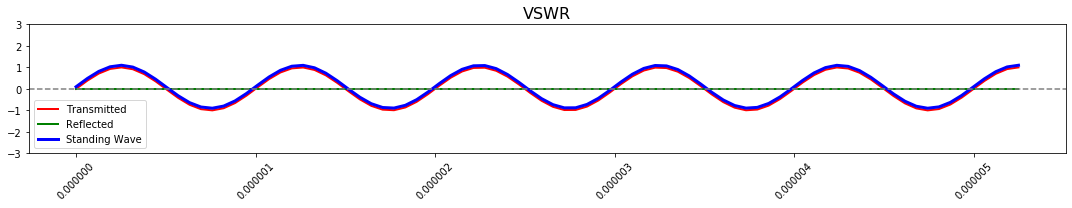

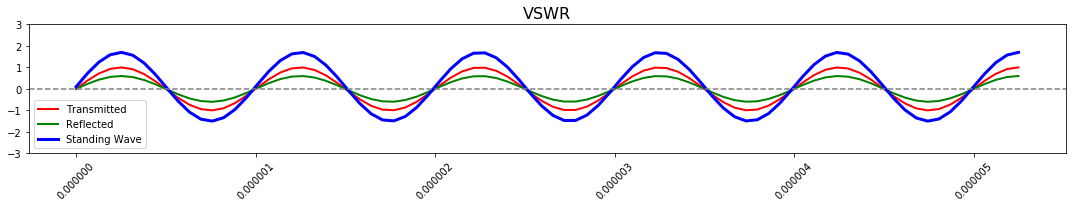

In [11]:
plot_wave(starting_phase = 0, Zl = 50)
plot_wave(starting_phase = 0, Zl = 200)
# plot_wave(starting_phase = PI2 / 4, Zo = 50, Zl = 75) 

## VSWR varies with $Z_{Load}$
- play with `starting_phase` and `Zl`

In [12]:
interactive(plot_wave, starting_phase = (0, PI2, PI2 / 16), Zl = (0, 1000, 25))

interactive(children=(FloatSlider(value=0.0, description='starting_phase', max=6.283185307179586, step=0.39269…

## Calculate VSWR at specific $Z_{Load}$

VSWR = 1.5000859097755788


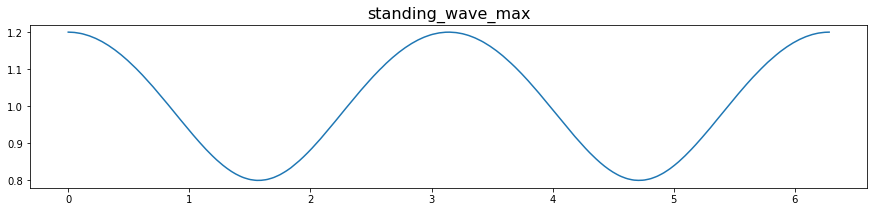

In [13]:
def get_phase_standing_wave_max(Zl = 50):
    
    phases = np.linspace(0, PI2, 360)
    standing_wave_max = []

    for phase in phases:
        wave, wave_reflect, wave_standing = get_wave(starting_phase = phase, Zl = Zl) 
        standing_wave_max.append(np.abs(wave_standing.ys).max()) 
        
    return phases, np.array(standing_wave_max)


def get_vswr(Zl = 50):    
    phases, standing_wave_max = get_phase_standing_wave_max(Zl = Zl)    
    
    plt.figure(figsize = (15, 3))
    plt.plot(phases, standing_wave_max);
    plt.title('standing_wave_max', fontsize = 16)
    VSWR = standing_wave_max.max() / standing_wave_max.min()
    return VSWR


VSWR = get_vswr(Zl = 75)
print('VSWR =', VSWR)